In [2]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import *
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.circuit.library import ZZFeatureMap
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.aqua.algorithms import QSVM
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.utils import reduce_dim_to_via_pca
from ibm_quantum_widgets import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.linalg import expm
from qiskit.aqua.components.multiclass_extensions import AllPairs
import math
import numpy as np
import matplotlib.pyplot as plt

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

seed = 1000
algorithm_globals.random_seed = seed #

In [3]:
#Instalar paquete scikit-feature selection
!pip install git+https://github.com/jundongl/scikit-feature.git#egg=skfeature

  Cloning https://github.com/jundongl/scikit-feature.git to /tmp/pip-install-jlbt61li/skfeature_0ae418920b88424da0606de2a56068c3
  Running command git clone -q https://github.com/jundongl/scikit-feature.git /tmp/pip-install-jlbt61li/skfeature_0ae418920b88424da0606de2a56068c3
  Created wheel for skfeature: filename=skfeature-1.0.0-py3-none-any.whl size=61507 sha256=a96ae91b94cf18a6b71b5703c73f445460fb152556c34f1ffff2ec50f99d9430
  Stored in directory: /tmp/pip-ephem-wheel-cache-z630hs52/wheels/ea/ca/0b/ea331396461510ff572967528a880848ef75cc192b2f6074eb
Successfully built skfeature


In [4]:
from skfeature.function.similarity_based import SPEC

# Leer datos

In [6]:
#Leer fichero de datos
data = pd.read_csv('ETL_Jerarquia_0_v1.csv', sep=';') #leer csv
#Guardar nombres de las columnas
colNames = data.columns
#Crear una copia del dataframe original
OriginalData=data.copy()
#Printear los primeros 5 casos
print(data.head(n=5))

            origh            resph  mehodCount  uriCount  useragentCount  \
0  192.168.202.79  192.168.229.251         200       200             200   
1  192.168.202.79  192.168.229.153           1         1               1   
2  192.168.202.79  192.168.229.101           1         1               1   
3  192.168.202.79  192.168.229.156           1         1               1   
4  192.168.202.76   192.168.28.102           4         4               4   

  requestbodylen_Mean responsebodylenMean   Ano  Mes  dia  diasemana  hora  \
0            0.000000         155.935.000  2012    3   16          6    12   
1            0.000000         326.000.000  2012    3   16          6    12   
2            0.000000         238.000.000  2012    3   16          6    12   
3            0.000000         287.000.000  2012    3   16          6    12   
4            0.000000         169.000.000  2012    3   16          6    12   

   minuto  RecordCount  
0      30          200  
1      30            1  

# Preproceso de datos

In [7]:
#Preprocesar columnas 0-1 (IPs) y 5-6 (valores con millares representados con puntos) 
#Quitar puntos de las columnas
#Columna de IPs
print(data.iloc[:,0].head(n=4))
for i in np.array([0,1,5,6]):
    data.iloc[:,i] = data.iloc[:,i].apply(lambda x: x.replace('.',''))

print("Valor despues de preprocesar puntos: {}".format(data.iloc[0,0]))

0    192.168.202.79
1    192.168.202.79
2    192.168.202.79
3    192.168.202.79
Name: origh, dtype: object
Valor despues de preprocesar puntos: 19216820279


## Eliminar filas que contienen IPv6

In [8]:
#Eliminar filas con IPv6, no se pueden representar como numeros para el qPCA
#Todos los IPv6s comienzan con 2001:dbb, comprobar si hay : entre las posiciones 3 y 5 del string
#para saber si es IPv6
indicesFilas=[]
for i in range (0,len(data)):
    if (data.iloc[i,0].find(':',3,5)!=-1):
        indicesFilas.append(i)

#Eliminar las filas con IPs detectadas como IPv6
data=data.drop(indicesFilas)

#Printear tipos de columnas
print(data.dtypes)
#Poner las columnas preprocesadas en tipo integer ()
data=data.astype('int64') 

origh                  object
resph                  object
mehodCount              int64
uriCount                int64
useragentCount          int64
requestbodylen_Mean    object
responsebodylenMean    object
Ano                     int64
Mes                     int64
dia                     int64
diasemana               int64
hora                    int64
minuto                  int64
RecordCount             int64
dtype: object


## Estandarizar datos

In [9]:
#Estandarizar datos 
data=StandardScaler().fit_transform(data)
#Pasar datos a dataframe 
data=pd.DataFrame(data)
#Reasignar los nombres a las columnas
data.columns = colNames
print(data.head(n=3))

      origh     resph  mehodCount  uriCount  useragentCount  \
0 -1.037148  2.356561   -0.041078 -0.041078       -0.041078   
1 -1.037148  2.356561   -0.121386 -0.121386       -0.121386   
2 -1.037148  2.356561   -0.121386 -0.121386       -0.121386   

   requestbodylen_Mean  responsebodylenMean  Ano  Mes       dia  diasemana  \
0             -0.07588            -0.022519  0.0  0.0 -0.610326  -0.610326   
1             -0.07588            -0.022203  0.0  0.0 -0.610326  -0.610326   
2             -0.07588            -0.022367  0.0  0.0 -0.610326  -0.610326   

       hora    minuto  RecordCount  
0 -1.843207  0.055657    -0.041078  
1 -1.843207  0.055657    -0.121386  
2 -1.843207  0.055657    -0.121386  


# Feature Selection (Spectral)

In [9]:
kwargs = {'style': 1}
feats=SPEC.spec(data.to_numpy(), **kwargs)
print(feats)

[    0.     0.     0.     0.     0.     0.     0. -1000. -1000.     0.
     0.     0.     0.     0.]


In [10]:
#Indices de mayor a menor de los valores de ranking del SPEC feature selection
index = feats.argsort()[::-1]
fsData=data.iloc[:,index[0:4]]

print("Variables seleccionadas: \n", fsData.columns)

Variables seleccionadas: 
 Index(['RecordCount', 'minuto', 'hora', 'diasemana'], dtype='object')


# Feature selection correlation

In [10]:
#Correlaciones entre variables ordenadas de mayor a menor eliminando los pares centrales
correlations=data.corr(method='kendall').abs().unstack().sort_values(ascending=True).drop_duplicates().dropna()
print("Variables con mayor correlacion: \n",correlations)

Variables con mayor correlacion: 
 origh                minuto                 0.001879
diasemana            RecordCount            0.003432
resph                useragentCount         0.006262
minuto               hora                   0.007318
mehodCount           minuto                 0.007425
dia                  responsebodylenMean    0.008262
resph                hora                   0.008976
minuto               resph                  0.010158
hora                 responsebodylenMean    0.013268
minuto               requestbodylen_Mean    0.016068
                     responsebodylenMean    0.017317
useragentCount       hora                   0.018063
minuto               diasemana              0.021749
hora                 diasemana              0.030112
requestbodylen_Mean  dia                    0.034196
useragentCount       origh                  0.050353
responsebodylenMean  origh                  0.064199
requestbodylen_Mean  origh                  0.072335
resph      

In [11]:
#Obtener los nombres de los dos pares de variables menos correladas
feats=list(correlations.index[0]+correlations.index[1])
#Escoger las variables de la base de datos original
fsData=data[feats]
print("Variables seleccionadas: \n", fsData.columns)

Variables seleccionadas: 
 Index(['origh', 'minuto', 'diasemana', 'RecordCount'], dtype='object')


# PCA

Eigenvalores: 
 [1.15424417 1.01364385 0.93552748 0.89717395]
Porcentaje varianza explicada: 
 [28.85185268 25.33736239 23.38474089 22.42604405]
Porcentaje varianza acumulada: 
 [ 28.85185268  54.18921506  77.57395595 100.        ]


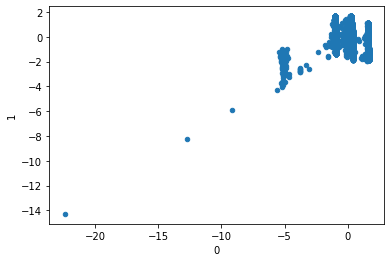

In [12]:
#Matriz de covarianza de los datos
#cmat = np.cov(data, rowvar=False)
cmat = np.cov(fsData, rowvar=False)
#print("Matriz de covarianza: \n",cmat.head(n=5)

#Calcular eigenvalores y eigenvectores
eigenval,eigenvec = np.linalg.eig(cmat)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index = eigenval.argsort()[::-1]
eigenval=eigenval[index]
eigenvec=eigenvec[:,index]
print("Eigenvalores: \n",eigenval.real)
#print("Eigenvectores: \n",eigenvec)

explainedVar=eigenval/sum(eigenval)*100
print("Porcentaje varianza explicada: \n", explainedVar.real)
cumVar = explainedVar.cumsum()
print("Porcentaje varianza acumulada: \n", cumVar.real)

#Proyeccion en las nuevas componentes: proyeccion=X(datos)*Eigenvectors(en columnas)
#pcaCoords=np.dot(data, eigenvec[:,0:2].real)
pcaCoords=np.dot(fsData, eigenvec[:,0:2].real)
pcaCoords=pd.DataFrame(pcaCoords)
#Plot con pandas
pcaCoords.plot.scatter(x=0,y=1)

#Obtener las tres primeras componentes del pca para el QSVM
#qsvmData =np.dot(data, eigenvec[:,0:3].real)
qsvmData =np.dot(fsData, eigenvec[:,0:3])

# QSVRegresor

In [18]:
#Mapa de caracteristicas
feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')
#Instanciacion del simulador
backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)
#Crear quantum kernel con el mapa de caracteristicas y el simulador
kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
#qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension=AllPairs())
qsvr = QSVR(quantum_kernel = kernel)

## Prueba fit 100

In [19]:
#Coger 100 filas aleatorias entre la base de datos para la parte de fitting
np.random.seed(999)
ind=np.random.randint(0,len(qsvmData),size = 100)
X=qsvmData[ind,1:3]#.reshape(-1,2)
y=qsvmData[ind,0]
try:
    qsvr.fit(X, y)
except Exception:
    print("Runtime error")

In [20]:
#Eliminar los casos escogidos para la fase de fitting
#newData=[element for i, element in enumerate(qsvmData) if i not in ind]
#print("Tamaño de la nueva base de datos: {}, y de la original: {}".format(len(newData),len(qsvmData)))
output=np.empty(len(qsvmData))
for i in range (0,len(qsvmData),100):
    #Separar el ultimo caso con menos de 100 datos
    if i==6700:
        output[i:i+87]=qsvr.predict(qsvmData[i:i+87,1:3])
    else:
        output[i:i+100]=qsvr.predict(qsvmData[i:i+100,1:3])    
    
    print("Indice: ", i)

#print(qsvr.predict(X).head(n=20))
#print("Real values: \n", y[0:21])

Indice:  0
Indice:  100
Indice:  200
Indice:  300
Indice:  400
Indice:  500
Indice:  600
Indice:  700
Indice:  800
Indice:  900
Indice:  1000
Indice:  1100
Indice:  1200
Indice:  1300
Indice:  1400
Indice:  1500
Indice:  1600
Indice:  1700
Indice:  1800
Indice:  1900
Indice:  2000
Indice:  2100
Indice:  2200
Indice:  2300
Indice:  2400
Indice:  2500
Indice:  2600
Indice:  2700
Indice:  2800
Indice:  2900
Indice:  3000
Indice:  3100
Indice:  3200
Indice:  3300
Indice:  3400
Indice:  3500
Indice:  3600
Indice:  3700
Indice:  3800
Indice:  3900
Indice:  4000
Indice:  4100
Indice:  4200
Indice:  4300
Indice:  4400
Indice:  4500
Indice:  4600
Indice:  4700
Indice:  4800
Indice:  4900
Indice:  5000
Indice:  5100
Indice:  5200
Indice:  5300
Indice:  5400
Indice:  5500
Indice:  5600
Indice:  5700
Indice:  5800
Indice:  5900
Indice:  6000
Indice:  6100
Indice:  6200
Indice:  6300
Indice:  6400
Indice:  6500
Indice:  6600
Indice:  6700


## Guardar predicciones en un fichero

In [21]:
print(output[0:5])
#np.savetxt('predicciones.csv', output, delimiter=',', fmt='%1.8f')#Escribir en fichero con 8 decimales de precision
np.savetxt('prediccionesCA.csv', output, delimiter=',', fmt='%1.8f')#Escribir en fichero con 8 decimales de precision

[ 0.17082674  0.09449028  0.09449028  0.09449028 -0.22135757]


In [4]:
#output=pd.read_csv('predicciones.csv', sep=',', header=None).to_numpy().reshape(-1) #leer fichero de predicciones
output=pd.read_csv('prediccionesCA.csv', sep=',', header=None).to_numpy().reshape(-1) #leer fichero de predicciones
print(output[0:5])

[-0.19019764  0.03515346  0.03515346  0.03515346 -0.61006027]


In [22]:
#Calcular el error: sqrt((a-b)^2)
errors = [math.sqrt((qsvmData[i,0]-output[i])**2) for i in range(len(qsvmData[:,0]))]
print(errors[0:5])

[1.2060755927395184, 1.146990118188089, 1.146990118188089, 1.146990118188089, 0.5406107176258975]


In [23]:
#Crear columna de fecha (uniendo las columnas de año, mes, dia, hora y minuto)
OriginalData["Fecha"] = pd.to_datetime(OriginalData["Ano"].astype(str) +'-'+ OriginalData["Mes"].astype(str) +'-'+ OriginalData["dia"].astype(str) +' '+ OriginalData["hora"].astype(str) +':'+ OriginalData["minuto"].astype(str))  
#Convertir el vector de errores en columna de pandas
OriginalData["Error"] = pd.Series(errors)
print(OriginalData.head(5))

            origh            resph  mehodCount  uriCount  useragentCount  \
0  192.168.202.79  192.168.229.251         200       200             200   
1  192.168.202.79  192.168.229.153           1         1               1   
2  192.168.202.79  192.168.229.101           1         1               1   
3  192.168.202.79  192.168.229.156           1         1               1   
4  192.168.202.76   192.168.28.102           4         4               4   

  requestbodylen_Mean responsebodylenMean   Ano  Mes  dia  diasemana  hora  \
0            0.000000         155.935.000  2012    3   16          6    12   
1            0.000000         326.000.000  2012    3   16          6    12   
2            0.000000         238.000.000  2012    3   16          6    12   
3            0.000000         287.000.000  2012    3   16          6    12   
4            0.000000         169.000.000  2012    3   16          6    12   

   minuto  RecordCount               Fecha     Error  
0      30          

<AxesSubplot:xlabel='Fecha', ylabel='Error'>

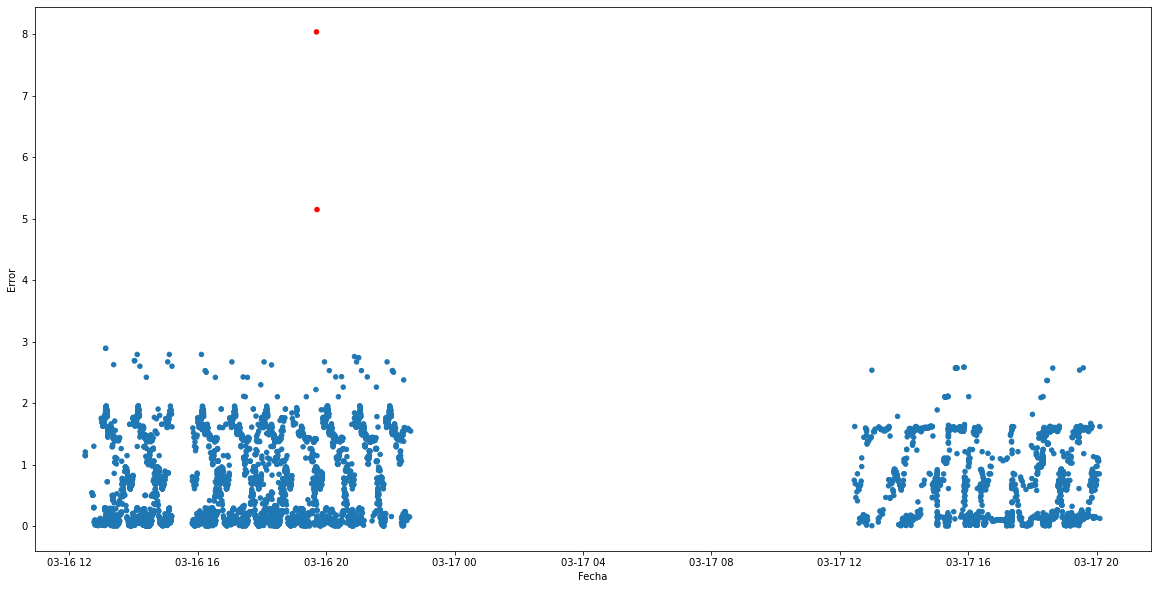

In [25]:
from matplotlib.pyplot import figure
#Color dependiendo del error obtenido
#col = np.where(OriginalData["Error"]>25,'r','C0')#pca clasico
#col = np.where(OriginalData["Error"]>7.5,'r','C0')#feature selection
col = np.where(OriginalData["Error"]>5,'r','C0')#eigenvec circuito
OriginalData.plot.scatter(x="Fecha", y ="Error", figsize=(20,10), c=col)

# Pruebas eigenvalues a mano

In [13]:
#Función para calcular el eigenvalue correspondiente al eigenvector v, 
#la matriz de covarianza covmat y el conjunto de datos data
#Devuelve el eigenvector y la matriz de covarianza actualizada
def eigenvalue(v, covmat, data):    
    #Calcular las proyecciones de cada punto al eigenvector: ((P*u1)/(u1*u1)*u1
    projections=data.to_numpy().dot(v)/np.dot(v,v)
    #Multiplicar vector con todos los escalares por el vector unitario (primer eigenvector)
    pointProjections=np.outer(projections,v)
    #Calcular las distancias de todos los puntos obtenidos al origen
    zero=np.zeros(data.shape[1])
    #Calcular las distancias al cuadrado de todos los puntos projectados y el origen para obtener el eigenvalue
    distance=np.linalg.norm(pointProjections - zero)**2
    #Dividir el eigenvalue entre n-1 para obtener la variacion del componente pc1
    eigenvalue=distance/6786
    #Actualzar matriz de covarianza, B=A-lambda1*(v*v^T)/(v*v)^2
    cmatUpdated=covmat-eigenvalue*np.outer(v,v)/(np.dot(v,v)**2)
    
    #Devolver el eigenvalue obtenido y la matriz de covarianza actualizada
    return round(eigenvalue,8), cmatUpdated

xd, c=eigenvalue(eigenvec[:,0],cmat,fsData)

In [78]:
#Calcular las proyecciones de cada punto al eigenvector: ((P*u1)/(u1*u1)*u1
v=eigenvec[:,0].real
#Metodo 1 (apply mas lento):
#pointProjections=pd.DataFrame(data.apply(lambda x: (np.dot(x,v)/np.dot(v,v))*v, axis=1))
#print(pointProjections.head(5))

#Metodo 2: 
projections=data.to_numpy().dot(v)/np.dot(v,v)
#Multiplicar vector con todos los escalares por el vector unitario (primer eigenvector)
pointProjections=np.outer(projections,v)
print(pointProjections[0:5,:])

[[-1.59562714e-02  3.62457382e-02  1.43331621e-01  1.43331621e-01
   1.43331621e-01 -2.62985527e-03 -2.72529531e-04 -0.00000000e+00
  -0.00000000e+00 -2.17324013e-02 -2.17324013e-02  1.11327371e-02
   3.71290116e-03  1.43331621e-01]
 [-7.29602834e-03  1.65734166e-02  6.55385927e-02  6.55385927e-02
   6.55385927e-02 -1.20250516e-03 -1.24614525e-04 -0.00000000e+00
  -0.00000000e+00 -9.93717219e-03 -9.93717219e-03  5.09046025e-03
   1.69772947e-03  6.55385927e-02]
 [-7.29603673e-03  1.65734357e-02  6.55386680e-02  6.55386680e-02
   6.55386680e-02 -1.20250654e-03 -1.24614669e-04 -0.00000000e+00
  -0.00000000e+00 -9.93718361e-03 -9.93718361e-03  5.09046610e-03
   1.69773142e-03  6.55386680e-02]
 [-7.29603206e-03  1.65734251e-02  6.55386261e-02  6.55386261e-02
   6.55386261e-02 -1.20250577e-03 -1.24614589e-04 -0.00000000e+00
  -0.00000000e+00 -9.93717725e-03 -9.93717725e-03  5.09046284e-03
   1.69773033e-03  6.55386261e-02]
 [ 1.07363508e-02 -2.43883393e-02 -9.64422405e-02 -9.64422405e-02
  

In [11]:
#Calcular las distancias de todos los puntos obtenidos al origen
zero=np.zeros(data.shape[1])
#Calcular las distancias al cuadrado de todos los puntos projectados y el origen para obtener el eigenvalue
distance=np.linalg.norm(pointProjections - zero)**2
#Dividir el eigenvalue entre n-1 para obtener la variacion del componente pc1
eigenvalue1=distance/6786
print(eigenvalue1)

4.074108013728111


In [46]:
#Actualzar matriz de covarianza, B=A-lambda1*(v*v^T)/(v*v)^2
cmatUpdated=cmat-eigenvalue1*np.outer(v,v)/(np.dot(v,v)**2)
print(cmat[0:2,0:2])
print(cmatUpdated[0:2,0:2])

[[ 1.00014736 -0.09305641]
 [-0.09305641  1.00014736]]
[[ 0.98792013 -0.06528143]
 [-0.06528143  0.93705466]]


In [50]:
eigenval2,eigenvec2 = np.linalg.eig(cmatUpdated)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index2 = eigenval2.argsort()[::-1]
eigenval2=eigenval2[index2]
eigenvec2=eigenvec2[:,index2]
print("Mayor eigenvalue despues de aplicar formula: ",eigenval2.real[0])
print("Segundo mayor eigenvalue antes de aplicar formula: ",eigenval.real[1])


Mayor eigenvalue despues de aplicar formula:  2.081786773762993
Segundo mayor eigenvalue antes de aplicar formula:  2.0817867737629974


In [ ]:
#Matriz de covarianza de los datos
cmat = np.cov(data, rowvar=False)
#print("Matriz de covarianza: \n",cmat.head(n=5)

#Calcular eigenvalores y eigenvectores
eigenval,eigenvec = np.linalg.eig(cmat)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index = eigenval.argsort()[::-1]
eigenval=eigenval[index]
eigenvec=eigenvec[:,index]

# Circuito 4 qubits

In [13]:
#Matriz de covarianza de los datos
cmat = np.cov(fsData, rowvar=False)
#print("Matriz de covarianza: \n",cmat.head(n=5)

#Calcular eigenvalores y eigenvectores
eigenval,eigenvec = np.linalg.eig(cmat)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index = eigenval.argsort()[::-1]
eigenval=eigenval[index]
eigenvec=eigenvec[:,index]

print("Eigenvalores: \n",eigenval.real)
print("Eigenvectores: \n",eigenvec)

Eigenvalores: 
 [1.15424417 1.01364385 0.93552748 0.89717395]
Eigenvectores: 
 [[ 0.61241355  0.00663358 -0.41338126 -0.67381123]
 [ 0.029735   -0.91820528  0.34444069 -0.19332744]
 [ 0.60443664 -0.23179233 -0.27003895  0.71274654]
 [-0.50864705 -0.32113451 -0.79847073  0.02439886]]


In [14]:
p=cmat/cmat.trace()

In [76]:
#Inicializar vector de estado (superposicion)
stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
stateVec2 = [1/np.sqrt(2), 1/np.sqrt(2)]
#Repetir proceso para mayor precision
for i in range(0, 5):
    #Crear circuito con 5 qubits
    circuit = QuantumCircuit(6,6)
    #Inicializacion qubit 4 en estado de superposicion
    circuit.initialize(stateVec, 4)
    circuit.initialize(stateVec2, 5)
    #Aplicar puertas de hadamard a qubits 0,1,2,3 para aplicar Quantum Amplitude Estimation sobre la matriz unitaria
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    #Calcular rotaciones de la puerta de la matriz unitaria
    (theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p))
    #Aplicar rotaciones
    circuit.cu3(theta,phi,lamb, 3, [4,5])
    #Calcular rotaciones de la puerta de la matriz unitaria aplicada dos veces, Quantum Amplitude Estimation
    (theta2, phi2, lamb2) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*2))
    #Aplicar rotaciones
    circuit.cu3(theta2,phi2,lamb2, 2, [4,5])
    #Calcular rotaciones de la puerta de la matriz unitaria aplicada cuatro veces, Quantum Amplitude Estimation
    (theta3, phi3, lamb3) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*4))
    #Aplicar rotaciones
    circuit.cu3(theta3,phi3,lamb3, 1, [4,5])
    #Calcular rotaciones de la puerta de la matriz unitaria aplicada ocho veces, Quantum Amplitude Estimation
    (theta4, phi4, lamb4) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*8))
    #Aplicar rotaciones
    circuit.cu3(theta4,phi4,lamb4, 0, [4,5])
    
    #Aplicar Quantum Fourier Transform en los qubits 0,1,2,3
    circuit.h(0)
    circuit.crz(-np.pi/2,0,1)
    circuit.h(1)
    circuit.crz(-np.pi/2,1,2)
    circuit.crz(-np.pi/4,0,2)
    circuit.h(2)
    circuit.crz(-np.pi/2,2,3)
    circuit.crz(-np.pi/4,1,3)
    circuit.crz(-np.pi/8,0,3)
    circuit.h(3)
    
    #Medir los qubits
    circuit.measure([0,1,2,3,4,5], [0,1,2,3,4,5])
    #Ejecutar circuito en el simulador y guardar resultados obtenidos
    results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=10000).result().get_counts()
    #print(results)
    denominator = results['001111'] + results['011111'] + results['101111'] + results['111111']
    
    #Calcular coeficientes del eigenvector
    alpha1 = np.sqrt(results['001111'] / denominator)
    alpha2 = np.sqrt(results['011111'] / denominator)
    alpha3 = np.sqrt(results['101111'] / denominator)
    alpha4 = np.sqrt(results['111111'] / denominator)
    
    #Guardar nuevo estado inicial para la siguiente ejecucion
    stateVec = [alpha1, alpha2]
    stateVec2 = [alpha3, alpha4]

print("Eigenvector obtenido: ",stateVec, stateVec2)

<ipython-input-76-7a10ad86c5d9>:19: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  circuit.cu3(theta,phi,lamb, 3, [4,5])


Traceback (most recent call last):
  File "<ipython-input-76-7a10ad86c5d9>", line 9, in <module>
    circuit.initialize(stateVec, 4)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/extensions/quantum_initializer/initializer.py", line 455, in initialize
    return self.append(Initialize(params, num_qubits), qubits)
  File "/opt/conda/lib/python3.8/site-packages/qiskit/extensions/quantum_initializer/initializer.py", line 91, in __init__
    raise QiskitError("Sum of amplitudes-squared does not equal one.")
QiskitError: 'Sum of amplitudes-squared does not equal one.'

Use %tb to get the full traceback.


## Prueba sin loop

In [82]:
stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
stateVec2 = [1/np.sqrt(2), 1/np.sqrt(2)]
#Crear circuito con 5 qubits
circuit = QuantumCircuit(6,6)

#Inicializacion qubit 4 en estado de superposicion
circuit.initialize(stateVec, 4)
circuit.initialize(stateVec2, 5)

#Aplicar puertas de hadamard a qubits 0,1,2,3 para aplicar Quantum Amplitude Estimation sobre la matriz unitaria
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)

#Calcular rotaciones de la puerta de la matriz unitaria
(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p))
#Aplicar rotaciones
circuit.cu(theta,phi,lamb,0, 3, [4,5])
#Calcular rotaciones de la puerta de la matriz unitaria aplicada dos veces, Quantum Amplitude Estimation
(theta2, phi2, lamb2) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*2))
#Aplicar rotaciones
circuit.cu(theta2,phi2,lamb2,0, 2, [4,5])
#Calcular rotaciones de la puerta de la matriz unitaria aplicada cuatro veces, Quantum Amplitude Estimation
(theta3, phi3, lamb3) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*4))
#Aplicar rotaciones
circuit.cu(theta3,phi3,lamb3,0, 1, [4,5])
#Calcular rotaciones de la puerta de la matriz unitaria aplicada ocho veces, Quantum Amplitude Estimation
(theta4, phi4, lamb4) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*8))
#Aplicar rotaciones
circuit.cu(theta4,phi4,lamb4,0, 0, [4,5])

#Aplicar Quantum Fourier Transform en los qubits 0,1,2,3
circuit.h(0)
circuit.crz(-np.pi/2,0,1)
circuit.h(1)
circuit.crz(-np.pi/2,1,2)
circuit.crz(-np.pi/4,0,2)
circuit.h(2)
circuit.crz(-np.pi/2,2,3)
circuit.crz(-np.pi/4,1,3)
circuit.crz(-np.pi/8,0,3)
circuit.h(3)

#Medir los qubits
circuit.measure([0,1,2,3,4,5], [0,1,2,3,4,5])
#Ejecutar circuito en el simulador y guardar resultados obtenidos
results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=10000).result().get_counts()
denominator = results['001111'] + results['011111'] + results['101111'] + results['111111']
    
#Calcular coeficientes del eigenvector en proyeccion 1111 (00,01,10,11); segunda proyeccion en 1110 segundo eigenvec????? 
alpha1 = np.sqrt(results['001111'] / denominator)
alpha2 = np.sqrt(results['011111'] / denominator)
alpha3 = np.sqrt(results['101111'] / denominator)
alpha4 = np.sqrt(results['111111'] / denominator)

#Guardar nuevo estado inicial para la siguiente ejecucion
stateVec = [alpha1, alpha2]
stateVec2 = [alpha3, alpha4]

print("Eigenvector obtenido: ", stateVec + stateVec2)

Eigenvector obtenido:  [0.2586530658057318, 0.6581022652668016, 0.6251760315483433, 0.33038603114760284]


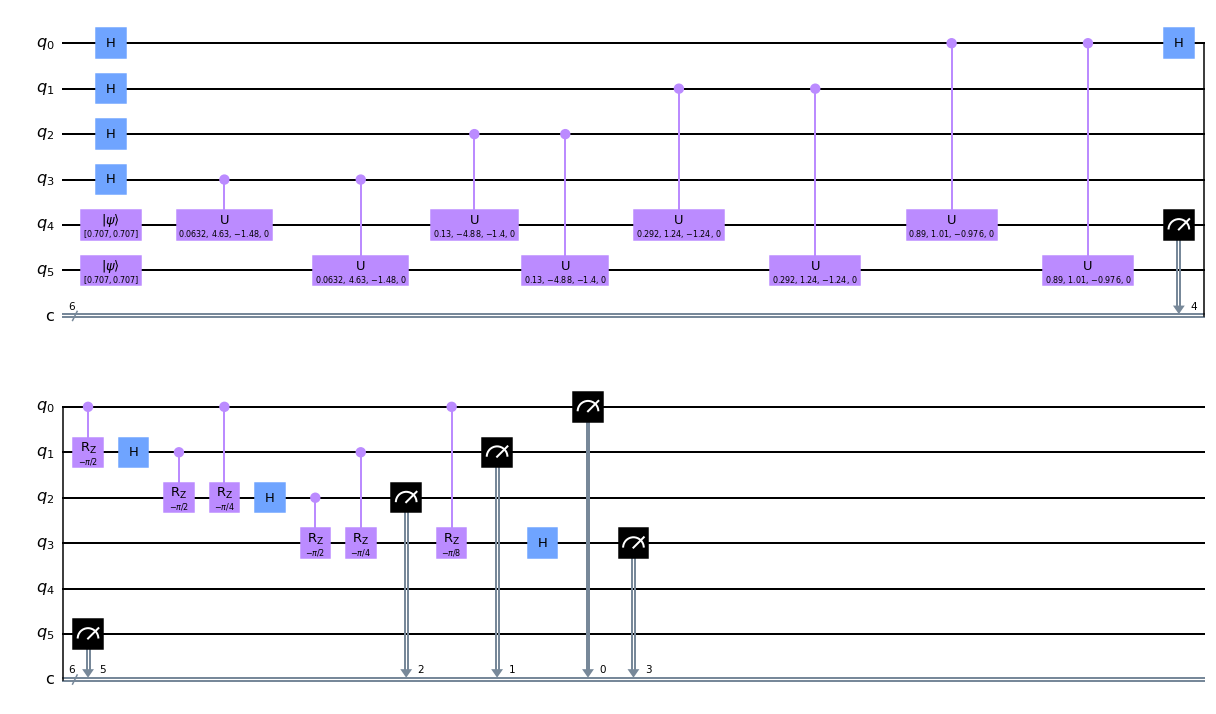

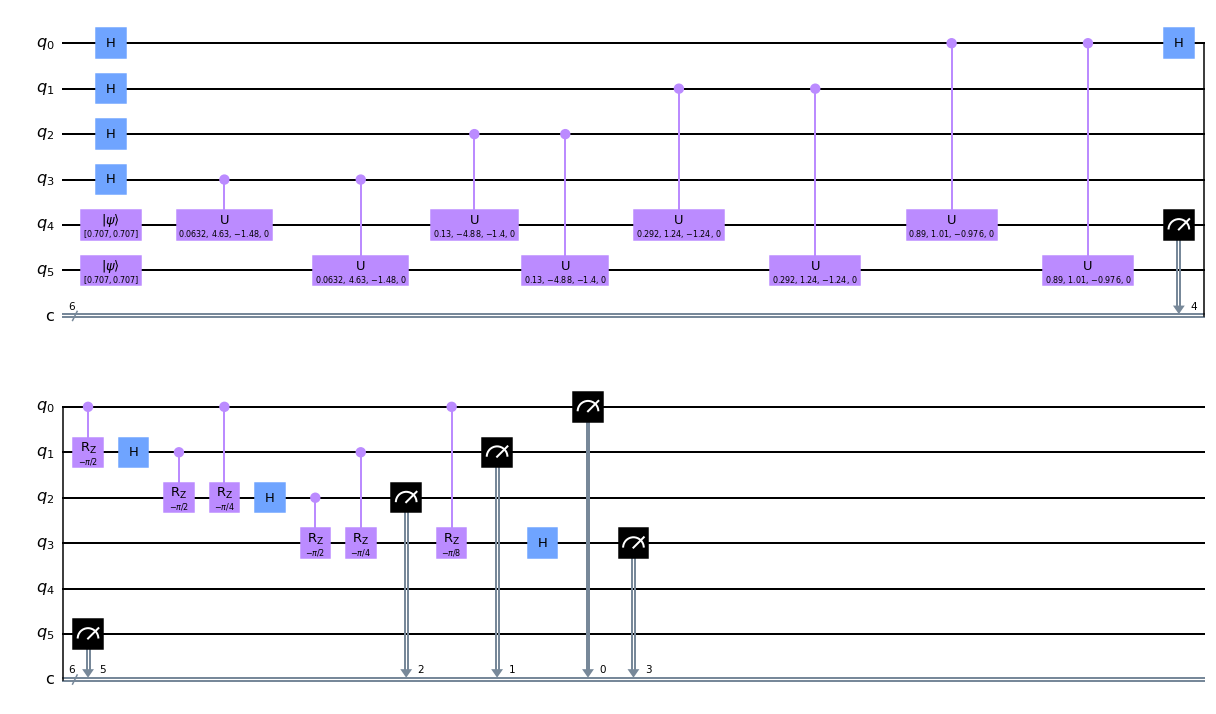

In [83]:
circuit.draw(output='mpl')

In [14]:
#Creacion del circuito QPE con n qubits superiores y m inferiores, la matriz de covarianza normalizada p y el vector estado
def QPE(n,m,p, stateVector):
    #Circuito con n+m qubits y bits clasicos
    #qpeCircuit=QuantumCircuit(n+m,n+m)
    qpeCircuit=QuantumCircuit(n+m)
    #Indices de los n qubits superiores
    nNumbers=np.arange(0,n).tolist()
    #Aplicar puertas de hadamard a los qubits superiores
    qpeCircuit.h(nNumbers)
    
    #Indices de los m qubits inferiores
    mNumbers=np.arange(n,n+m).tolist()
    #Iniciar m qubits inferiores con el vector de estado
    for i in range(n,n+m):
        #qpeCircuit.initialize(stateVector,i)
        qpeCircuit.ry(1,i)
        qpeCircuit.rz(0.33,i)
    
    #Aplicar las puertas controladas de U entre los qubits superiores e inferiores
    for i in range(0,n):
        #Calcular rotacion de la matriz de covarianza para la puerta controlada U
        (theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*(2**i)))
        #Aplicar rotaciones theta, phi, lambda, gamma=0
        qpeCircuit.cu(theta,phi,lamb, 0, n-1-i, mNumbers)
    
    #Llamar a la funcion de creacion de IQFT para los n qubits superiores
    iqftC=IQFT(n) 
    #Combinar los dos circuitos
    xd=QuantumCircuit.compose(qpeCircuit,iqftC)
    #Realizar las mediciones
    #xd.measure(nNumbers+mNumbers,nNumbers+mNumbers)
    xd.measure_all()
    return xd


#Creacion del circuito Inverse Quantum Fourier Transform con n qubits  
def IQFT(n):
    #Definir circuito de n qubits y n bits clasicos
    #iqftCircuit=QuantumCircuit(n,n)
    iqftCircuit=QuantumCircuit(n)
    
    #Aplicar las rotaciones respectivas a cada qubit, desde el 0 hasta el n-1
    for i in range(0,n):
        for j in range(0,i):
            iqftCircuit.crz(-np.pi/(2**(j+1)), (i-1-j),i)
        
        #Aplicar puerta de hadamard despues de aplicar las rotaciones en cada qubit
        iqftCircuit.h(i)    
    return iqftCircuit

#Creacion del circuito Inverse Quantum Fourier Transform con n qubits, Metodo 2 (paper Finances)
def IQFT2(n):
    iqftCircuit=QuantumCircuit(n)
    #Aplicar las rotaciones respectivas a cada qubit, desde el 0 hasta el n-1
    for i in range(0,n):
        #Aplicar puerta de hadamard antes de aplicar las rotaciones en cada qubit
        iqftCircuit.h(i)
        for j in range(i,n-1):
            iqftCircuit.crz(-np.pi/(2**(j+1)), i,j+1)
    return iqftCircuit

In [20]:
#Matriz de covarianza de los datos
cmat = np.cov(fsData, rowvar=False)
p=cmat/cmat.trace()

Eigenvector obtenido:  [0.7303806420989957, 0.39201590603983827, 0.4017425280245165, 0.3891922253017063]


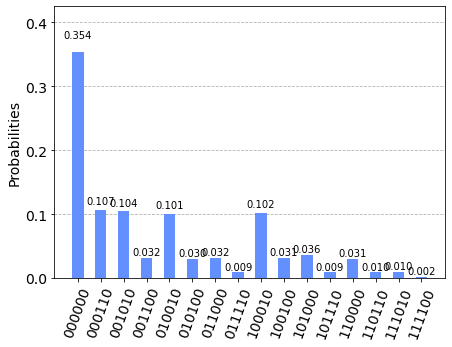

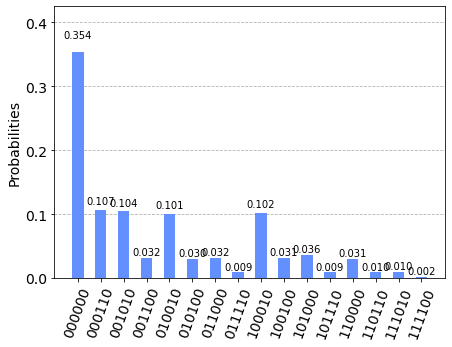

In [22]:
#Inicializar vector de estado |+>
stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
for i in range(0,10):
    circuit=QPE(2,4,p,stateVec)
    results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
    #Conteo de los estados relacionados con la proyeccion 11 (011 y 111)
    denominator = results['000000'] + results['100010'] + results['000110'] + results['010010']
    #Calcular coeficientes del eigenvector
    alpha1 = np.sqrt(results['000000'] / denominator)
    alpha2 = np.sqrt(results['100010'] / denominator)
    alpha3 = np.sqrt(results['000110'] / denominator)
    alpha4 = np.sqrt(results['010010'] / denominator)
    #Guardar nuevo estado inicial del qubit 2 para la siguiente ejecucion
    stateVec = [alpha1, alpha2]
    stateVec2= [alpha3, alpha4]
print("Eigenvector obtenido: ",stateVec+stateVec2)
plot_histogram(results)

In [16]:
#Funcion para calcular el eigenvector dada la matriz de densidad (matriz cov normalizada por la traza)
def circuitEigenvector(p):
    #Inicializar vector de estado |+>
    stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
    for i in range(0,10):
        circuit=QPE(2,2,p,stateVec)
        results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
        #Obtener los nombres de los resultados por orden de conteos de mayor a menor
        arra=np.array(list(results.values()))
        index = arra.argsort()[::-1]
        arra=arra[index]
        key=np.array(list(results.keys()))[index]
        #Conteo de los estados relacionados con la proyeccion 11 (011 y 111)
        denominator = results[key[0]]+results[key[1]]+results[key[2]]+results[key[3]]
        #Calcular coeficientes del eigenvector
        alpha1 = np.sqrt(results[key[0]] / denominator)
        alpha2 = np.sqrt(results[key[1]] / denominator)
        alpha3 = np.sqrt(results[key[2]] / denominator)
        alpha4 = np.sqrt(results[key[3]] / denominator)
        #Guardar nuevo estado inicial del qubit 2 para la siguiente ejecucion
        stateVec = [alpha1, alpha2]
        stateVec2= [alpha3, alpha4]
        print("Eigenvector obtenido: ",stateVec+stateVec2)
        return stateVec+stateVec2

In [17]:
#Matriz de covarianza de los datos
cmat = np.cov(fsData, rowvar=False)
#Matriz de densidad
p=cmat/cmat.trace()

eigenvectors=np.zeros((len(cmat),3))
eigenvalues=np.zeros(3)
for i in range(0, len(eigenvectors)-1):
    ev=circuitEigenvector(p)
    eigenvalue1,cmat=eigenvalue(np.asarray(ev), cmat, fsData)
    eigenvectors[:,i]=ev
    p=cmat/cmat.trace()
    eigenvalues[i]=eigenvalue1
print(eigenvectors)
print(eigenvalues)

qsvmData =np.dot(fsData, eigenvectors[:,0:3])

Eigenvector obtenido:  [0.7670586067895986, 0.43666214414006627, 0.4180965050081141, 0.214808235701055]
Eigenvector obtenido:  [0.7336685564672593, 0.40739830351122835, 0.4058638411717844, 0.3619828918287513]
Eigenvector obtenido:  [0.8061138223506886, 0.3991998185126933, 0.39595687430897347, 0.1844943468024506]
[[0.76705861 0.73366856 0.80611382]
 [0.43666214 0.4073983  0.39919982]
 [0.41809651 0.40586384 0.39595687]
 [0.21480824 0.36198289 0.18449435]]
[1.04253404 1.01860109 1.04445631]


In [69]:
print(eigenval)
xd,c=eigenvalue(eigenvec[:,0], cmat, fsData)
eiv,ev=np.linalg.eig(c)
print(eiv)

[1.15424417 1.01364385 0.93552748 0.89717395]
[-13.32780159   0.21207261   0.8259705    0.95687106]
